### Load models, determine how many fires fell in high risk zone and generate maps

In [1]:
import pandas as pd
import Modelling_tools as MT
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import folium
import seaborn as sns
from folium.plugins import MarkerCluster
%matplotlib inline

In [2]:
print (folium.__file__)
print (folium.__version__)

/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/folium/__init__.py
0.7.0


#### Load models and determine boundaries on the hazard zone designations

In [9]:
fileloc = "/Users/rmartinshort/Documents/Insight/Project/FirescapeSF/firescapeapp/models/"

In [10]:
model_SF = pickle.load(open(fileloc+'RC_model_SF_2018.sav', 'rb'))
model_EF = pickle.load(open(fileloc+'RC_model_EF_2018.sav', 'rb'))
model_VF = pickle.load(open(fileloc+'RC_model_VF_2018.sav', 'rb'))

In [11]:
dataset = pd.read_csv("/Users/rmartinshort/Documents/Insight/Project/census_block_prediction/Fully_merged_dataset_Autogenerated_plus.csv")

In [12]:
#Do something about the NaNs
dataset['UnkownUseType'].fillna(1,inplace=True)
dataset['S'].fillna(1,inplace=True)
values = {'COMH':0, 'COMM':0, 'COMO':0, 'COMR':0, 'GOVT':0, 'IND':0, 'MISC':0,
       'MRES':0, 'SRES':0, 'A':0, 'B':0, 'C':0, 'D':0}
dataset = dataset.fillna(value=values)
dataset.fillna(dataset.mean(),inplace=True)

In [13]:
dataset.drop(['IDyear_x.1'],inplace=True,axis=1)

In [14]:
#Structural
X,y,XholdoutSF,yholdoutSF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='SF_pred',yearto_holdout=2018)

In [15]:
#External
X,y,XholdoutEF,yholdoutEF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='EF_pred',yearto_holdout=2018)

In [16]:
##Vehicle 
X,y,XholdoutVF,yholdoutVF,Xuseforfuture,holdout,use_for_future = MT.setupdataset(dataset,fire_to_predict='VF_pred',yearto_holdout=2018)

In [17]:
GISCELLS = list(holdout['GISYEARJOIN'])
SF_blocks_years = gpd.read_file('SF_block_years_2010.shp')
mapdata = SF_blocks_years[SF_blocks_years['GISYEARJOI'].isin(GISCELLS)]

In [18]:
#Predict fire probs for 2018
SF_2018_pred = model_SF.predict_proba(XholdoutSF)
VF_2018_pred = model_VF.predict_proba(XholdoutVF)
EF_2018_pred = model_EF.predict_proba(XholdoutEF)

In [19]:
def classify(val):
    if val > 0:
        return 1
    else:
        return 0

#### Determine the mean number of fires that happen per year

In [20]:
print(max(dataset['EF_pred']))
dataset['contains_EF'] = dataset['EF_pred'].apply(classify)
dataset['contains_SF'] = dataset['SF_pred'].apply(classify)
dataset['contains_VF'] = dataset['VF_pred'].apply(classify)
dataset[['GISYEARJOIN','IDyear_x','contains_SF','contains_VF','contains_EF']].groupby('IDyear_x').sum().iloc[:-1].describe()

17.0


,contains_SF,contains_VF,contains_EF
count,11.000000,11.000000,11.000000
mean,288.363636,178.454545,558.363636
std,26.242228,34.940989,201.396759
min,260.000000,118.000000,328.000000
25%,276.500000,161.000000,385.500000
50%,283.000000,176.000000,484.000000
75%,290.500000,197.500000,780.000000
max,359.000000,242.000000,812.000000


In [21]:
#Normalize the fire probability scores
fscoreSF = 10.0*SF_2018_pred[:,1]
fscoreVF = 10.0*VF_2018_pred[:,1]
fscoreEF = 10.0*EF_2018_pred[:,1]

In [22]:
#Find the thresholds for high risk zones
ncells_EF = 560
ncells_SF = 290
ncells_VF = 180
vallimEF = sorted(fscoreEF)[::-1][ncells_EF]
vallimSF = sorted(fscoreSF)[::-1][ncells_SF]
vallimVF = sorted(fscoreVF)[::-1][ncells_VF]
print(vallimEF,vallimSF,vallimVF)

8.063062644933392 7.182010416452735 7.473523313862332


In [23]:
fscoreEFHI = fscoreEF.copy()
fscoreEFHI[fscoreEFHI<=vallimEF]=0
fscoreEFHI[fscoreEFHI>vallimEF]=1

fscoreSFHI = fscoreSF.copy()
fscoreSFHI[fscoreSFHI<=vallimSF]=0
fscoreSFHI[fscoreSFHI>vallimSF]=1

fscoreVFHI = fscoreVF.copy()
fscoreVFHI[fscoreVFHI<=vallimVF]=0
fscoreVFHI[fscoreVFHI>vallimVF]=1

In [24]:
riskmap_2018 = gpd.GeoDataFrame({'geometry':mapdata['geometry'],'fprob_EF':fscoreEF,
                        'fprob_VF':fscoreVF,'fprob_SF':fscoreSF,'GISYEARJOIN':mapdata['GISYEARJOI']})

In [25]:
#The _pred columns contains the number of fires that actually happened per
#cell in 2018
cells_fires_2018 = holdout[['GISYEARJOIN','Structure_fire','External_fire','Vehicle_fire','EF_pred','VF_pred','SF_pred']]

### How many external fires did we 'catch'?

In [53]:
#Sort riskmap by fires
ncells = 560
EF_top_cells = riskmap_2018.sort_values(by='fprob_EF',ascending=False).iloc[:ncells]

#If a cell has fprob of greater than this value, it should be deemed high risk 
print(EF_top_cells.iloc[-1])

#Get the block location information about these cells
EF_top_cells = EF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')

#This is the proportion of the total number of exernal fires that occured within the highest risk cells
prop_ef_cells = EF_top_cells['External_fire'].apply(classify).sum()/ncells

#This is the proportion of 2018 blocks that experienced fires that we would have caught if we selected
#blocks at random
expected_prop_ef_cells = cells_fires_2018['EF_pred'].apply(classify).sum()/len(cells_fires_2018)

topcells_prev_fire = cells_fires_2018.sort_values(by='External_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the ncells highest risk cells
prop_ef_cells_past = topcells_prev_fire['EF_pred'].apply(classify).sum()/ncells

geometry       POLYGON ((-122.4116059995596 37.77622100028506...
fprob_EF                                                 8.06373
fprob_VF                                                 6.21528
fprob_SF                                                  7.5414
GISYEARJOIN                               G060075001760130052017
Name: 62746, dtype: object


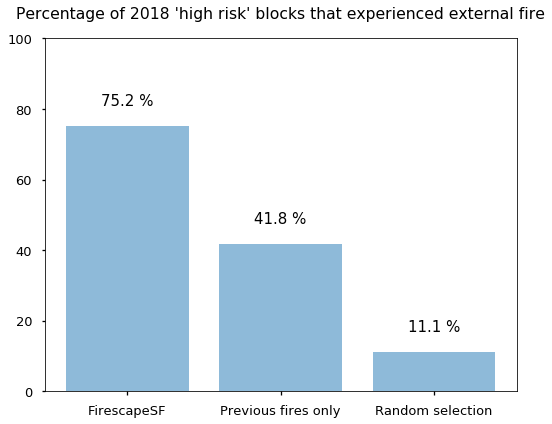

In [54]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_ef_cells*100,prop_ef_cells_past*100,expected_prop_ef_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 'high risk' blocks that experienced external fire",pad=20)
plt.tight_layout()
plt.savefig("External_fires_proportionsNN.png",dpi=400)

### Structural fires

In [51]:
#Sort riskmap by fires
ncells = 290 #SF
SF_top_cells = riskmap_2018.sort_values(by='fprob_SF',ascending=False).iloc[:ncells]

#If a cell has fprob of greater than this value, it should be deemed high risk 
print(SF_top_cells.iloc[-1])

SF_top_cells = SF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_sf_cells = SF_top_cells['Structure_fire'].apply(classify).sum()/ncells
expected_prop_sf_cells = cells_fires_2018['SF_pred'].apply(classify).sum()/len(cells_fires_2018)

topcells_prev_fire = cells_fires_2018.sort_values(by='Structure_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the highest risk cells
prop_sf_cells_past = topcells_prev_fire['SF_pred'].apply(classify).sum()/ncells

geometry       POLYGON ((-122.435052000511 37.77821299990733,...
fprob_EF                                                   8.515
fprob_VF                                                 5.48493
fprob_SF                                                 7.18276
GISYEARJOIN                               G060075001580220012017
Name: 56722, dtype: object


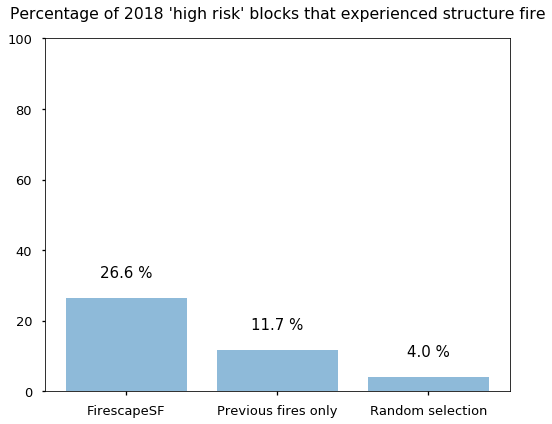

In [52]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_sf_cells*100,prop_sf_cells_past*100,expected_prop_sf_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 'high risk' blocks that experienced structure fire",pad=20)
plt.tight_layout()
plt.savefig("Structural_fires_proportionsNN.png",dpi=400)

### Vehicle fires

In [49]:
#Sort riskmap by fires
ncells = 180 #VF
VF_top_cells = riskmap_2018.sort_values(by='fprob_VF',ascending=False).iloc[:ncells]

#If a cell has fprob of greater than this value, it should be deemed high risk 
print(VF_top_cells.iloc[-1])

VF_top_cells = VF_top_cells.merge(cells_fires_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_vf_cells = VF_top_cells['VF_pred'].apply(classify).sum()/ncells
expected_prop_vf_cells = cells_fires_2018['VF_pred'].apply(classify).sum()/len(cells_fires_2018)

topcells_prev_fire = cells_fires_2018.sort_values(by='Vehicle_fire',ascending=False).iloc[:ncells]
topcells_prev_fire = topcells_prev_fire.merge(riskmap_2018,how='inner',on='GISYEARJOIN')
#This is the proportion of the total number of exernal fires that occured within the 800 highest risk cells
prop_vf_cells_past = topcells_prev_fire['VF_pred'].apply(classify).sum()/ncells

geometry       POLYGON ((-122.3908359996855 37.71117000047644...
fprob_EF                                                 6.32708
fprob_VF                                                 7.47661
fprob_SF                                                 2.64251
GISYEARJOIN                               G060075006100010012017
Name: 42826, dtype: object


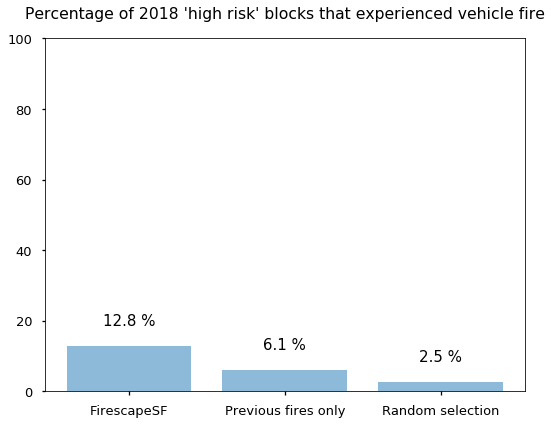

In [50]:
xlabels = ['FirescapeSF','Previous fires only','Random selection']
ylabels = [prop_vf_cells*100,prop_vf_cells_past*100,expected_prop_vf_cells*100]

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.bar(xlabels,ylabels,alpha=0.5)
ax1.set_ylim([0,100])
rects = ax1.patches 

for rect, label in zip(rects, ylabels):
    label = '%.1f %%' %label
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=15)
ax1.set_title("Percentage of 2018 'high risk' blocks that experienced vehicle fire",pad=20)
plt.tight_layout()
plt.savefig("Vehicle_fires_proportionsNN.png",dpi=400)

In [36]:
SF_2019_pred = model_SF.predict_proba(Xuseforfuture)
VF_2019_pred = model_VF.predict_proba(Xuseforfuture)
EF_2019_pred = model_EF.predict_proba(Xuseforfuture)

In [37]:
print(max(EF_2019_pred[:,1]))
print(max(EF_2018_pred[:,1]))

0.968478531093315
0.9699952755708208


/Users/rmartinshort/anaconda/envs/Insight/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Distibution of probability for 2019')

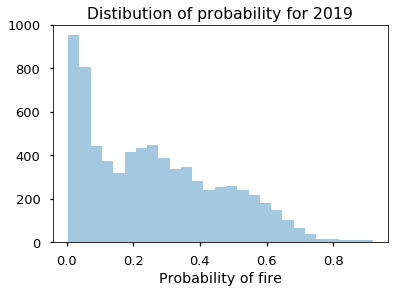

In [38]:
sns.distplot(SF_2019_pred[:,1],kde=False)
plt.xlabel('Probability of fire')
plt.title("Distibution of probability for 2019")

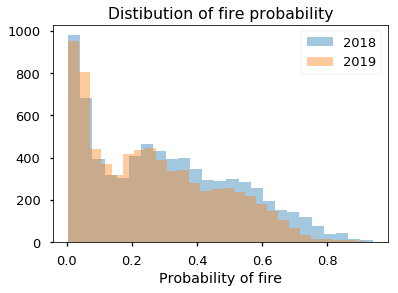

In [39]:
sns.distplot(SF_2018_pred[:,1],kde=False,label='2018')
sns.distplot(SF_2019_pred[:,1],kde=False,label='2019')
plt.xlabel('Probability of fire')
plt.title("Distibution of fire probability")
plt.legend(loc='best')
plt.savefig("Fire_prob_dist_SF_2018_2019.png",dpi=300)